In [3]:
import numpy as np
from numba import jit, njit
from matplotlib import pyplot as plt

# Dependence with copula

#### 1. Simulation of marginal distribution

In [83]:
mu1 = 0
sigma1 = 1
lam = 1
rho = 0.9

In [84]:
X1 = np.random.normal(mu1, sigma1)
X2 = np.random.exponential(1)

#### 2. Transform Marginals to Uniform

In [85]:
@njit
def erf_approx(x, n=1000):
    t = np.linspace(0, x, n)  # Points for integration
    dt = x / n  # Step size
    integral = 0.0
    for i in range(n):
        integral += np.exp(-t[i]**2) * dt
    return (2 / np.sqrt(np.pi)) * integral

In [86]:
@njit
def normal_cdf(x, mu, sigma):
    return 0.5 * (1 + erf_approx((x - mu) / (np.sqrt(2) * sigma)))

@njit
def expo_cdf(x, lam):
    return 1 - np.exp(- lam * x)

In [87]:
U1 = normal_cdf(X1, mu1, sigma1)
U2 = expo_cdf(X2, lam)

#### 3. Apply a Gaussian Copula

In [88]:
@njit
def normal_inverse_cdf(p, mu, sigma, tol=1e-6, max_iter=50):
    if p <= 0 or p >= 1:
        raise ValueError("p must be in the range (0, 1)")
    
    x = 0
    for _ in range(max_iter):
        error = 0.5 * (1 + erf_approx(x / np.sqrt(2))) - p
        derivative = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
        x -= error / derivative
        if abs(error) < tol:
            break
    
    return mu + sigma * x

@njit
def exponential_inverse_cdf(p, lam):
    return -1/lam * np.log(1 - p)

In [89]:
Z1 = normal_inverse_cdf(U1, 0, 1)
Z2 = normal_inverse_cdf(U2, 0, 1)

theta = np.linalg.cholesky(np.array([[1, rho],[rho, 1]]))
Z = np.dot(theta, np.array([Z1,Z2]))

In [90]:
V1 = 0.5 * (1 + erf_approx(Z[0] / np.sqrt(2)))
V2 = 0.5 * (1 + erf_approx(Z[1] / np.sqrt(2)))

In [91]:
Y1 = normal_inverse_cdf(V1, mu1, sigma1)
Y2 = exponential_inverse_cdf(V2, lam)

Put everything in a single function

In [92]:
def simulate_copula(mu1, sigma1, lam, rho, m):
    np.random.seed(13)
    theta = np.linalg.cholesky(np.array([[1, rho],[rho, 1]]))
    X1 = np.random.normal(mu1, sigma1, m)
    X2 = np.random.exponential(lam, m)
    N = np.zeros((2, m))
    Y = np.zeros((2, m))
    for i in range(m):
        N[:, i] = np.dot(theta, np.array([normal_inverse_cdf(normal_cdf(X1[i], mu1, sigma1), 0, 1),
                                         normal_inverse_cdf(expo_cdf(X2[i], lam), 0, 1)]))
        Y[0, i] = normal_inverse_cdf(0.5 * (1 + erf_approx(N[0, i] / np.sqrt(2))), mu1, sigma1)
        Y[1, i] = exponential_inverse_cdf(0.5 * (1 + erf_approx(N[1, i] / np.sqrt(2))), lam)
    return Y

In [93]:
Y = simulate_copula(mu1, sigma1, lam, rho, 1000)

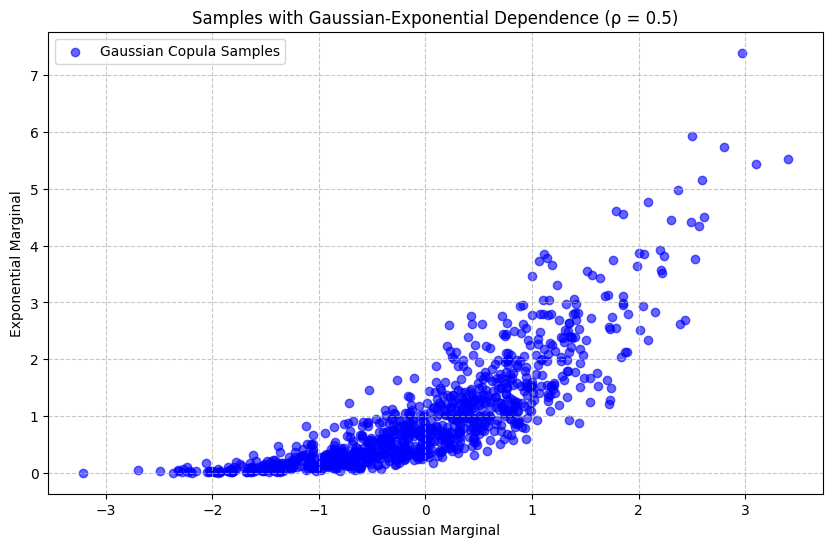

In [94]:
plt.figure(figsize=(10, 6))
plt.scatter(Y[0,:], Y[1,:], alpha=0.6, color='blue', label='Gaussian Copula Samples')
plt.xlabel("Gaussian Marginal")
plt.ylabel("Exponential Marginal")
plt.title("Samples with Gaussian-Exponential Dependence (ρ = 0.5)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Financial simulation with Clayton copula

In [128]:
theta = .01

The Clayton copula for parameter $\theta > 0$ is defined by $$C_\theta(u_1, u_2) = \left(\max\left(u_1^{-\theta} + u_2^{-\theta} - 1, 0\right)\right)^{-\frac{1}{\theta}}.$$

Let us make a first observation on the way we can think about it. We first simulate a uniform random variable $U_1 \sim \mathcal{U}([0,1])$. Then, we observe:
\begin{align*}
\mathbb{P}(U_2 \leq u_2 | U_1 = u_1) & = \int_{-\infty}^{u_2} f_{U_2|U_1}(u|u_1) \mathrm{d}u \\
& = \int_{-\infty}^{u_2} \frac{f_{(U_1, U_2)}(u_1, u)}{f_{U_1}(u_1)} \mathrm{d}u \\
& = \partial_{x}C(u_1, u_2)
\end{align*}

In [135]:
@njit
def simulate_clayton_copula(theta, n_samples):
    if theta <= 0:
        raise ValueError("Theta must be greater than 0")
    U = np.random.uniform(0,1, n_samples)
    V = (1 + U**(-theta) * (np.random.uniform(0,1, n_samples)**(-theta/(1 + theta)) -1))**(-1/theta)
    res = np.zeros((2, n_samples))
    for i in range(n_samples):
        res[0, i] = normal_inverse_cdf(U[i], 0, 1)
        res[1, i] = normal_inverse_cdf(V[i], 0, 1)
    return res

In [145]:
@njit
def simulate_price_copula(S0, mu, sigma, T, n_steps, theta):
    dt = T / n_steps 
    times = np.linspace(0, T, n_steps + 1) 
    prices = np.zeros((2, n_steps + 1)) 
    prices[:, 0] = S0
    W = simulate_clayton_copula(theta, n_steps + 1)
    for i in range(1, n_steps + 1):
        prices[:, i] = prices[:, i - 1] * np.exp(
            (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * W[:, i]
        )
    return prices, times

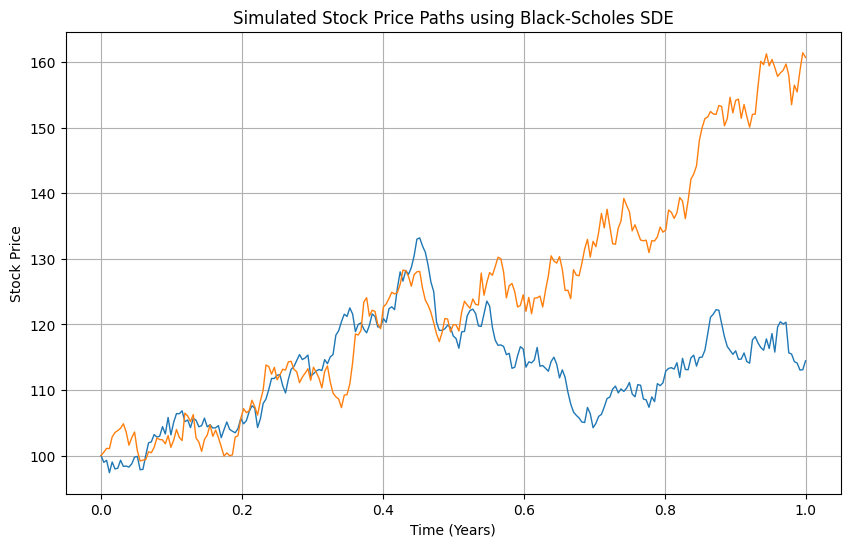

In [146]:
S0 = 100
mu = 0.05 
sigma = 0.2 
T = 1
n_steps = 252
theta = 0.2

prices, times = simulate_price_copula(S0, mu, sigma, T, n_steps, theta)

plt.figure(figsize=(10, 6))
for i in range(2):
    plt.plot(times, prices[i, :], lw=1)
plt.title("Simulated Stock Price Paths using Black-Scholes SDE")
plt.xlabel("Time (Years)")
plt.ylabel("Stock Price")
plt.grid()
plt.show()

In [150]:
cross_correlation = np.corrcoef(prices[0, :], prices[1, :])[0, 1]
print(f"Cross-correlation between asset prices: {cross_correlation:.4f}")

Cross-correlation between asset prices: 0.5128


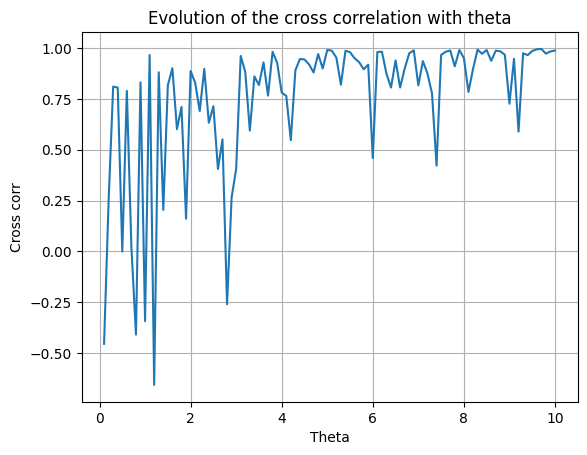

In [156]:
thetas = np.linspace(0.1, 10, 100) 
cross_corr = np.zeros(len(thetas))
for k in range(len(thetas)):
    theta = thetas[k]
    prices, times = simulate_price_copula(S0, mu, sigma, T, n_steps, theta)
    cross_correlation = np.corrcoef(prices[0, :], prices[1, :])[0, 1]
    cross_corr[k] = np.corrcoef(prices[0, :], prices[1, :])[0, 1]

plt.plot(thetas, cross_corr)

plt.title("Evolution of the cross correlation with theta")
plt.xlabel("Theta")
plt.ylabel("Cross corr")
plt.grid()
plt.show()

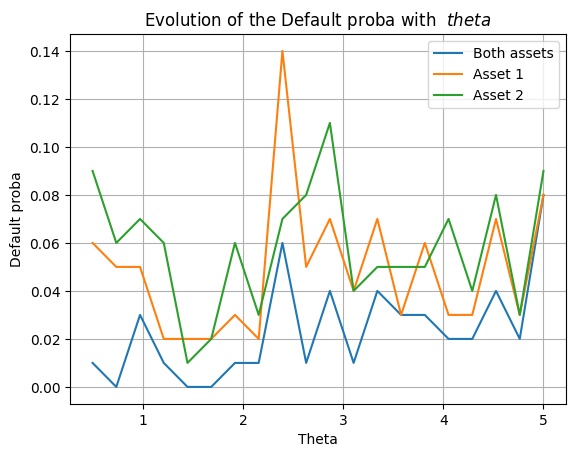

In [160]:
default_threshold = 70
m = 100

thetas = np.linspace(0.5, 5, 20) 
default_probabilities_1 = np.zeros(20)
default_probabilities_2 = np.zeros(20)
default_probabilities_b = np.zeros(20)

for k in range(len(thetas)):
    theta = thetas[k]
    p = 0
    p1 = 0
    p2 = 0
    for i in range(m):
        prices, times = simulate_price_copula(S0, mu, sigma, T, n_steps, theta)
        t1 = (np.min(prices[0, :]) < default_threshold)
        t2 = (np.min(prices[1, :]) < default_threshold)
        p += t1 and t2
        p1 += t1
        p2 += t2
        
    default_probabilities_b[k] = p/m
    default_probabilities_1[k] = p1/m
    default_probabilities_2[k] = p2/m

plt.plot(thetas, default_probabilities_b, label="Both assets")
plt.plot(thetas, default_probabilities_1, label="Asset 1")
plt.plot(thetas, default_probabilities_2, label="Asset 2")
plt.title("Evolution of the Default proba with $\ theta$")
plt.xlabel("Theta")
plt.ylabel("Default proba")
plt.legend()
plt.grid()
plt.show()